In [1]:
import os
import re
import math
import pandas as pd
import numpy as np
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
from shapely.geometry import shape, Point
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *

from IPython.core.display import display, HTML

# Turn slice copy warnings off
pd.options.mode.chained_assignment = None

import findspark
findspark.init()
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, FloatType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
data_folder = './data/'

### Crime Data Exploration

This dataset examins NYPD complaint data from 2006 through 2017, giving us information about crime trends throughout that time period. The data is taken from New York City's opendata website, and the exact source is given in our project's readme. Let's start off by writing the data to a parquet file, which we will load to cut down on run times.

#### Data Cleaning and Preprocessing

In [3]:
df = spark.read.csv(data_folder + "NYPD_Complaint_Data_Historic.csv")
df.write.mode("overwrite").parquet(data_folder + "nypd.parquet")
df = spark.read.parquet(data_folder + "nypd.parquet")

In [4]:
df.show(5)

+---------+----------+--------+----------+--------+---+----------+---+--------------------+---+--------------------+---------+-----------+---------+------+--------------------+----------------+----+----+----+----+-------+------+----+-----+----+----+------------+-------------+--------------------+--------------------+----+-----+-------+----+
|      _c0|       _c1|     _c2|       _c3|     _c4|_c5|       _c6|_c7|                 _c8|_c9|                _c10|     _c11|       _c12|     _c13|  _c14|                _c15|            _c16|_c17|_c18|_c19|_c20|   _c21|  _c22|_c23| _c24|_c25|_c26|        _c27|         _c28|                _c29|                _c30|_c31| _c32|   _c33|_c34|
+---------+----------+--------+----------+--------+---+----------+---+--------------------+---+--------------------+---------+-----------+---------+------+--------------------+----------------+----+----+----+----+-------+------+----+-----+----+----+------------+-------------+--------------------+-----------------

Let's rename the columns to column names from the dataset description to make future manipulations easier.

In [5]:
cols = ["Comp_Num", "Comp_FR_Date", "Comp_FR_Time", "Comp_TO_Date", "Comp_TO_TIME", "Addr_PCT_CD",\
       "RPT_DT", "KY_DC", "OFNS_DESC", "PD_CD", "PD_DESC", "Crime_Completed", "LAW_CAT_CD", "BORO_NM",\
        "LOC_OF_OCCUR", "PREM_TYPE", "JURIS_DESC", "JURIS_CODE", "PARKS_NM", "HADEVELOPT", "HOUSING_PSA",\
       "X_COORD_CD", "Y_COORD_CD", "SUSP_AGE_GROUP", "SUSP_RACE", "SUSP_SEX", "TRANS_DIST", "Latitude",\
       "Longitude", "Lat_Lon", "PATROL_BORO", "STATION_NAME", "VIC_AGE_GROUP", "VIC_RACE", "VIC_SEX"]
df = df.toDF(*cols)
df.show(5)

+---------+------------+------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+---------------+-----------+---------+------------+--------------------+----------------+----------+--------+----------+-----------+----------+----------+--------------+---------+--------+----------+------------+-------------+--------------------+--------------------+------------+-------------+--------+-------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|Comp_TO_Date|Comp_TO_TIME|Addr_PCT_CD|    RPT_DT|KY_DC|           OFNS_DESC|PD_CD|             PD_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR|           PREM_TYPE|      JURIS_DESC|JURIS_CODE|PARKS_NM|HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|TRANS_DIST|    Latitude|    Longitude|             Lat_Lon|         PATROL_BORO|STATION_NAME|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+---------+------------+------------+------------+------------+-----------+----------+-----+--

We can start off by immediately dropping the features which do not seem important. We will leave information on the time of the crime, information about the crime itself, and demographic information about the victim and the perpretrator.

In [6]:
drop_list = ["Comp_FR_", "HADEVELOPT", "HOUSING_PSA", "JURIS_CODE", "JURIS_DESC", "LOC_OF_OCCUR",\
            "PARKS_NM", "PREM_TYPE", "RPT_DT", "STATION_NAME", "PATROL_BORO", "TRANS_DIST",\
            "X_COORD_CD", "Y_COORD_CD", "Addr_PCT_CD", "Lat_Lon", "Comp_TO_Date", "Comp_TO_TIME",\
             "KY_DC", "PD_CD", "PD_DESC"]
df = df.select([column for column in df.columns if column not in drop_list])

In [7]:
df.show(5)

+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------+-------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------+-------+
|595775572|  10/30/2008|    12:00:00|       GRAND LARCENY|      COMPLETED|     FELONY| BROOKLYN|          null|    BLACK|       F|40.665617714|-73.899076401|          <18|   BLACK|      F|
|375177250|  10/30/2008|    12:00:00|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|MANHATTAN|          null|     null|    null|40.751600254|-73.992043061|         null| UNKNOWN|      D|
|513357035|  10/30/2008|    12:00:00|CRIMINAL MISCHIEF.

Let's now clean the data. Let's remove crimes with invalid date, time, and location data; as our intended visualization will involve maps and this invalid data makes up an extremely small proportion of the dataset, it makes more sense to just remove it.

In [8]:
df = df.where(df["Comp_FR_Date"].isNotNull())
df = df.where(df["Comp_FR_Time"].isNotNull())
df = df.where(df["Latitude"].isNotNull())

Let's now create a column that combines the date and time information into a single datetime column.

In [9]:
df.registerTempTable("df")
date = spark.sql("SELECT Comp_Num, CONCAT(Comp_FR_Date, ' ',  Comp_FR_Time) as Date FROM df")
df = df.join(date, ["Comp_Num"])
df = df.withColumn("Date", to_timestamp(df.Date, 'MM/dd/yyyy HH:mm:ss'))
df.show(5)

+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------+-------+-------------------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|               Date|
+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------+-------+-------------------+
|100027190|  08/01/2008|    17:23:00|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|MANHATTAN|          null|     null|    null|40.747327396|-73.976961498|         null|       UNKNOWN|      D|2008-08-01 17:23:00|
|100030303|  06/23/2016|    21:00:00|       GRAND LARCENY|      COMPLETED|     FELONY|    BRONX|          null|     null|    null|40.8638386

Let's now drop the old date and time columns, and write this to a parquet. This contains all of the information that we will need at the moment. In addition to this, our dataset only proports to be from 2006-2017; thus, let's also remove any rows with dates that are less than 2006.

In [10]:
df = df.drop("Comp_FR_Date").drop("Comp_FR_Time")
df = df.filter(df.Date >= lit("2006-01-01"))
df.write.mode("overwrite").parquet(data_folder + "nypd_filtered.parquet")

Loading the data again, we can now proceed with analysis of the data.

#### Crime Dataset Data Analysis

In [11]:
df = spark.read.parquet(data_folder + "nypd_filtered.parquet")

In [12]:
df.show(5)

+---------+--------------------+---------------+-----------+---------+--------------+--------------+--------+------------+-------------+-------------+--------------+-------+-------------------+
| Comp_Num|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|     SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|               Date|
+---------+--------------------+---------------+-----------+---------+--------------+--------------+--------+------------+-------------+-------------+--------------+-------+-------------------+
|100003098|OFFENSES AGAINST ...|      COMPLETED|MISDEMEANOR|MANHATTAN|         25-44|BLACK HISPANIC|       M|40.811130194|-73.936714506|        25-44|WHITE HISPANIC|      F|2014-10-02 13:40:00|
|100023642|CRIMINAL MISCHIEF...|      COMPLETED|     FELONY|    BRONX|         18-24|         BLACK|       M|40.791151867|-73.884371919|         null|       UNKNOWN|      E|2013-11-09 19:15:00|
|100038353|      FELONY ASSAUL

Let's first examine the offense descriptions, by finding the top ten most commonly occurring crimes.

In [13]:
df.registerTempTable("df")
query = """select OFNS_DESC, min(LAW_CAT_CD) as category, count(OFNS_DESC) as count 
    from df
    group by ofns_desc
    order by count desc
    limit 10"""
most_common = spark.sql(query).toPandas()
most_common.head()

,OFNS_DESC,category,count
0,PETIT LARCENY,MISDEMEANOR,981460
1,HARRASSMENT 2,VIOLATION,732754
2,ASSAULT 3 & RELATED OFFENSES,MISDEMEANOR,622173
3,CRIMINAL MISCHIEF & RELATED OF,FELONY,600613
4,GRAND LARCENY,FELONY,510969


<Figure size 432x288 with 0 Axes>

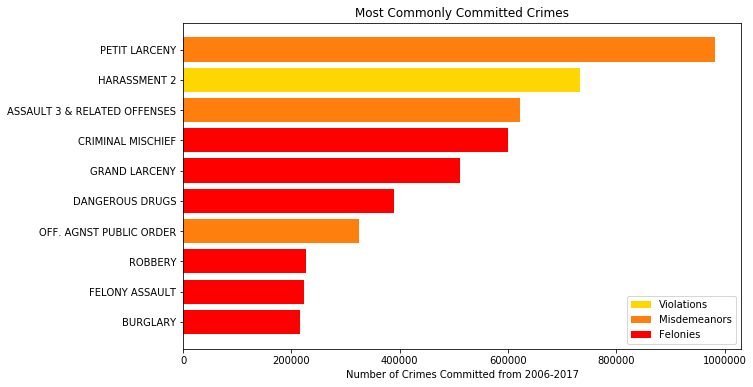

In [14]:
most_common.loc[3, "OFNS_DESC"] = "CRIMINAL MISCHIEF"
most_common.loc[6, "OFNS_DESC"] = "OFF. AGNST PUBLIC ORDER"
most_common.loc[1, "OFNS_DESC"] = "HARASSMENT 2"

# set colors
most_common.loc[most_common.category == "VIOLATION", "category"] = "gold"
most_common.loc[most_common.category == "MISDEMEANOR", "category"] = "C1"
most_common.loc[most_common.category == "FELONY", "category"] = "r"

# Dummy plots to create legend
red = plt.bar([1], [1], color="red")
gold = plt.bar([1], [1], color="gold")
orange = plt.bar([1], [1], color="C1")
plt.clf()

# reverse dataframe so graph is correct
most_common = most_common.iloc[::-1].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Most Commonly Committed Crimes")
plt.xlabel("Number of Crimes Committed from 2006-2017")
plt.barh(most_common["OFNS_DESC"], most_common["count"], color=most_common["category"])
plt.legend((gold, orange, red), ('Violations', 'Misdemeanors', 'Felonies'))

As can be seen, the most common crime committed is petit larceny, which New York defines to be the theft of objects with monetary value of no more than 1000 dollars. Grand larceny is also on the list, which is for items of value greater than 1000 dollars. Most of the items on the list are felonies (the most severe crimes), while only a few are misdemeanors (the least severe crime category). There is only one of the middle category on the list. Let's now examine the counts of the three categories in total.

In [15]:
df.groupBy("LAW_CAT_CD").count().sort(col("count").desc()).show()

+-----------+-------+
| LAW_CAT_CD|  count|
+-----------+-------+
|MISDEMEANOR|3414803|
|     FELONY|1839034|
|  VIOLATION| 745632|
+-----------+-------+



The majority of crimes committed are misdemeanors. Only 745,000 violations were committed over this timeframe, and 733,000 of them were in the "harassment 2" category, which corresponds with harrassment in the 2nd degree. Otherwise, we can see that nearly 1/3 of the felonies are criminal mischief charges, with grand larceny also taking up a similar proportion. 

Let's now look at the count per borough.

<BarContainer object of 5 artists>

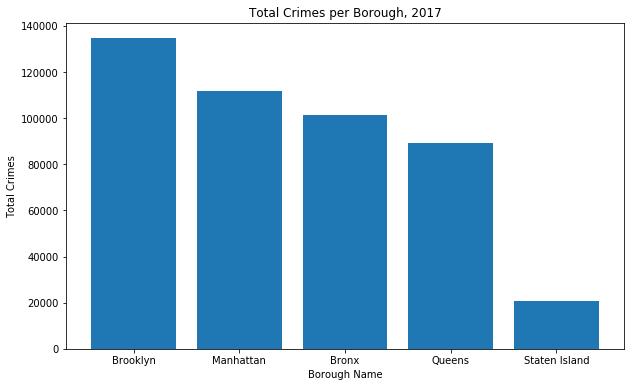

In [16]:
borough_counts = df.filter(year(df["Date"]) == 2017).groupBy("BORO_NM").count().sort(col("count").desc())
borough_counts = borough_counts.toPandas()
borough_counts = borough_counts.drop(5) # drop null values

# capitalize borough names properly
borough_counts["BORO_NM"] = borough_counts["BORO_NM"].apply(lambda x: x.lower().title())

# plot borough counts
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Total Crimes per Borough, 2017")
plt.ylabel("Total Crimes")
plt.xlabel("Borough Name")
plt.bar(borough_counts["BORO_NM"], borough_counts["count"])

Brooklyn has the most crimes committed by a decent margin, followed by Manhattan, the Bronx, and Queens. Staten Island is far behind, which makes sense due to its smaller size and population. Let's now examine how much crime happens in different hours of the day.

([<matplotlib.axis.XTick at 0x7fa628c2ac18>,
 <a list of 12 Text xticklabel objects>)

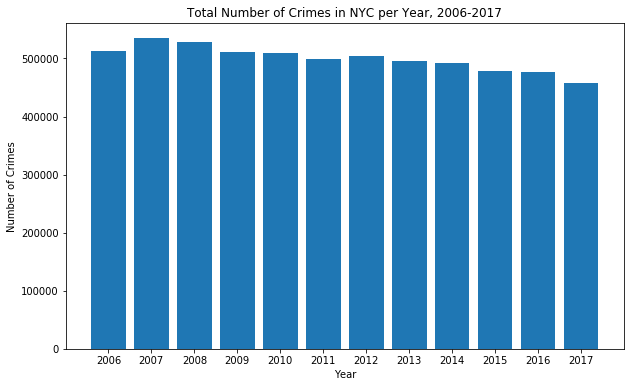

In [17]:
years = df.select(year("Date").alias("Year"))
years = years.groupBy("Year").count().orderBy(asc("Year")).toPandas()
# Plot year data
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Total Number of Crimes in NYC per Year, 2006-2017")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.bar(years["Year"], years["count"])
plt.xticks(np.arange(2006, 2018))

We observe that there is a downward trend for the crimes committed per year. Let's now examine patterns over smaller ranges of time, starting with the hour of the day.

In [18]:
hours = df.select("Date", "LAW_CAT_CD").withColumn("Hour", hour(df.Date)).drop("Date")
hours.groupBy("Hour").count().sort(col("Hour").asc()).show()

+----+------+
|Hour| count|
+----+------+
|   0|284045|
|   1|206995|
|   2|165946|
|   3|139862|
|   4|122590|
|   5| 85913|
|   6| 87574|
|   7|124400|
|   8|201464|
|   9|221439|
|  10|230515|
|  11|236269|
|  12|329199|
|  13|282808|
|  14|319956|
|  15|361601|
|  16|344267|
|  17|345283|
|  18|354435|
|  19|342792|
+----+------+
only showing top 20 rows



We can see from this table that the amount of crimes starts off fairly high, decreases as the night goes on,  and heats a peak in the mid-afternoon. Let's plot this data, along with the trends for each individual crime type.

In [19]:
total = hours.groupBy("Hour").count().sort(col("Hour").asc())
categories = hours.groupBy("Hour", "LAW_CAT_CD").count().orderBy(col("Hour").asc(), "LAW_CAT_CD")
total = total.toPandas()
categories = categories.toPandas()

<BarContainer object of 24 artists>

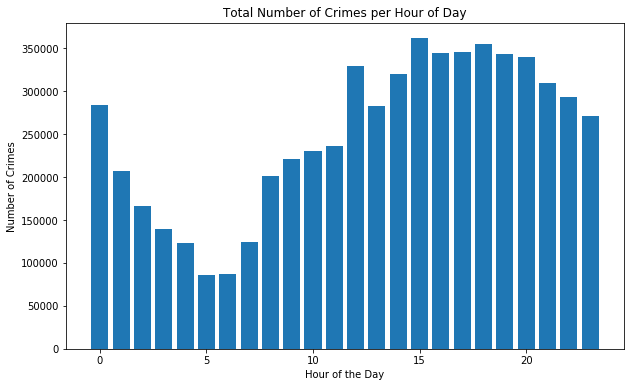

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Total Number of Crimes per Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes")
plt.bar(total["Hour"], total["count"])

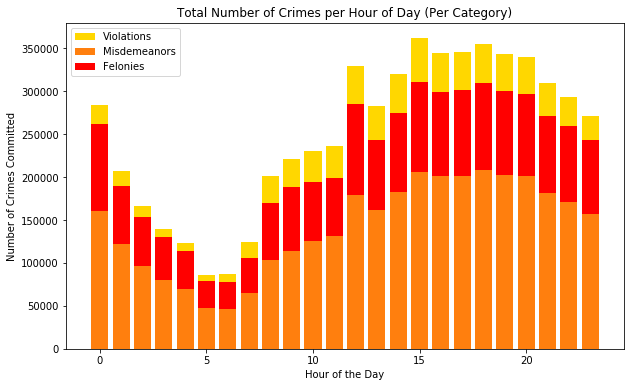

In [21]:
felonies = categories[categories.LAW_CAT_CD == "FELONY"].reset_index(drop=True)
misdemeanors = categories[categories.LAW_CAT_CD == "MISDEMEANOR"].reset_index(drop=True)
violations = categories[categories.LAW_CAT_CD == "VIOLATION"].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,6))
plt.title("Total Number of Crimes per Hour of Day (Per Category)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes Committed")

p1 = plt.bar(misdemeanors["Hour"], misdemeanors["count"], color="C1")
p2 = plt.bar(felonies["Hour"], felonies["count"], bottom=misdemeanors["count"], color="red")
p3 = plt.bar(violations["Hour"], violations["count"], bottom=(misdemeanors["count"] + felonies["count"]), color="gold")
plt.legend((p3[0], p1[0], p2[0]), ('Violations', 'Misdemeanors', 'Felonies'))

The individual categories follow a similar trend as the total. There is a consistent ordering between the number of misdemeanors, felonies, and violations for every hour. Let's see if we can find anything for the months of the year.

In [22]:
months = df.select(date_format('Date', 'MMM').alias("Month"), col("LAW_CAT_CD").alias("Category"))
month_counts = months.groupBy("Month").count()
month_counts = month_counts.toPandas()
month_counts['Month'] = pd.Categorical(month_counts["Month"], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
month_counts = month_counts.sort_values(by=["Month"])
month_counts.head()

,Month,count
9,Jan,488878
6,Feb,428642
8,Mar,494097
10,Apr,475603
4,May,528117


<BarContainer object of 12 artists>

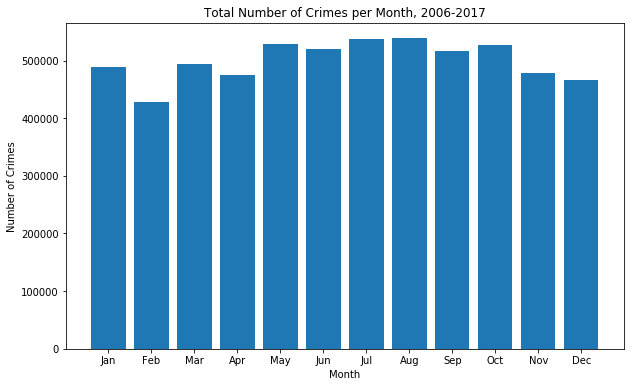

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Total Number of Crimes per Month, 2006-2017")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.bar(month_counts["Month"], month_counts["count"])

We observe a slight downtick in the November through April range, which corresponds to colder temperatures.

In [24]:
month_cats = months.groupBy(["Month", "Category"]).count()
month_cats = month_cats.toPandas()
month_cats['Month'] = pd.Categorical(month_cats["Month"], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
month_cats['Category'] = pd.Categorical(month_cats["Category"], categories=["VIOLATION", "MISDEMEANOR", "FELONY"], ordered=True)
month_cats = month_cats.sort_values(by=["Month", "Category"])
month_cats.head()

,Month,Category,count
3,Jan,VIOLATION,58587
21,Jan,MISDEMEANOR,279227
22,Jan,FELONY,151064
9,Feb,VIOLATION,51973
29,Feb,MISDEMEANOR,248509


We can convert the category names away from lowercase and create a stacked bar chart.

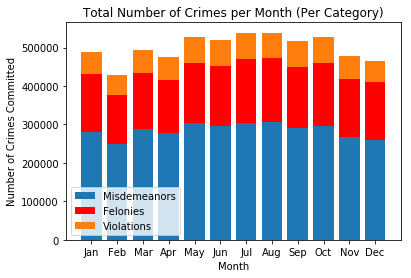

In [25]:
felonies = month_cats[month_cats.Category == "FELONY"].reset_index(drop=True)
misdemeanors = month_cats[month_cats.Category == "MISDEMEANOR"].reset_index(drop=True)
violations = month_cats[month_cats.Category == "VIOLATION"].reset_index(drop=True)

plt.title("Total Number of Crimes per Month (Per Category)")
plt.xlabel("Month")
plt.ylabel("Number of Crimes Committed")

p1 = plt.bar(misdemeanors["Month"], misdemeanors["count"])
p2 = plt.bar(felonies["Month"], felonies["count"], bottom=misdemeanors["count"], color="red")
p3 = plt.bar(violations["Month"], violations["count"], bottom=(misdemeanors["count"] + felonies["count"]), color="C1")
plt.legend((p1[0], p2[0], p3[0]), ('Misdemeanors', 'Felonies', 'Violations'))

The proportions remain similar throughout all the months, and no notable trends emerge. Let's now see how crime counts break down for the day of the week and hour of the day combined.

In [26]:
date = df.select(date_format('Date', 'E').alias('Day of the Week'), hour('Date').alias('Hour'))
date.show(5)

+---------------+----+
|Day of the Week|Hour|
+---------------+----+
|            Thu|  13|
|            Sat|  19|
|            Tue|  12|
|            Tue|   9|
|            Mon|  11|
+---------------+----+
only showing top 5 rows



Each row represents the combination of day of the week and hour of the day for each crime committed. Let's now group by each combination and display.

In [27]:
crime_times = date.groupBy(["Day of the Week", "Hour"]).count()
crime_times = crime_times.toPandas()
# add ordering for day of the week
crime_times['Day of the Week'] = pd.Categorical(crime_times['Day of the Week'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
crime_times = crime_times.sort_values(by=["Day of the Week", "Hour"])
crime_times.head()

,Day of the Week,Hour,count
40,Mon,0,35890
100,Mon,1,22814
16,Mon,2,17241
126,Mon,3,13836
15,Mon,4,12617


We now have all the combinations for day of the week and hour of the day.

In [28]:
crime_times = crime_times.pivot("Day of the Week", "Hour", "count")

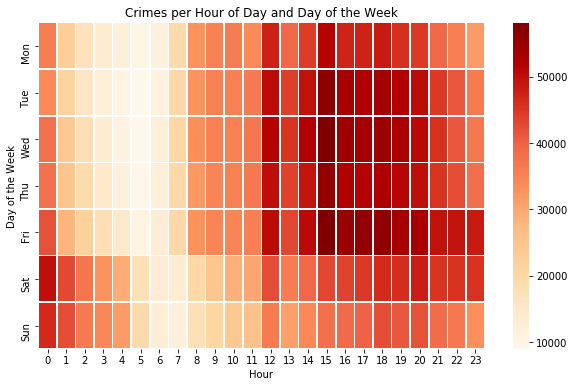

In [29]:
fig, ax = plt.subplots(figsize=(10,6))         # Sample figsize in inches
plt.title("Crimes per Hour of Day and Day of the Week")
sns.heatmap(crime_times, linewidths=.5, ax=ax, cmap="OrRd")